In [194]:
from IPython.display import display, Math, Latex

# Generalized Autoregressive Conditionally Heteroskedastic Models (GARCH)

## Time Series Models:

- Autoregressive- AR
- Moving Average- MA
- Autoregressive Moving Average - ARMA(p,q)
- Autoregressive Integrated Moving Average - ARIMA(p,d,q)
- Generalized Autoregressive Conditionally Heteroskedastic Models - GARCH(p,q)

### Autoregressive - AR(p)


$$x_{t} = a_{1}x_{t-1} +... a_{p}x_{t-p} + \epsilon _{t}$$
$$= \sum_{i=1}^{P}a_{i}x_{t-i} + \epsilon_{t}$$

$$\epsilon = white noise$$

AR-2 Equation: $$x_{t} = a_{1}x_{t-1} + a_{2}x_{t-2} + \epsilon _{t}$$

### Moving Average - MA(q)

$$x_{t} = \epsilon_{t} + \beta_{1}\epsilon_{t-1}+...+\beta_{p}\epsilon_{t-p}$$
$$= \epsilon_{t} + \sum_{i=1}^{P}\beta_{i}\epsilon_{t-i}$$

$$\epsilon = white noise$$

### Autoregressive Moving Average - ARMA(p,q)

Combination of AR and MA models:

$$x_{t}=a_{1}x_{t-1}+a_{2}x_{t-2}+...+\epsilon_{t}+\beta_{1}\epsilon_{t-1}+\beta_{2}\epsilon_{t-2}...+\beta_{q}\epsilon_{t-q}$$
$$=\sum_{i=1}^{P}a_{i}x_{t-i}+\epsilon_{t}+\sum_{i=1}^{Q}\beta_{i}\epsilon_{t-i}$$

### Autoregressive Conditionally Heteroskedastic - ARCH(p)

- AR(p) model applied to the variance of a time series (as opposed to the mean)

- variability in variance

https://i.stack.imgur.com/RXQv9.png![image.png](attachment:image.png)

$$\epsilon_{t} = \sigma_{t}z_{t}$$
$$\sigma_{t}^{2} = a_{0} + a_{1}\epsilon_{t-1}^{2}+...+a_{p}\epsilon_{t-p}^{2}$$
$$=a_{0} + \sum_{i=1}^{P}a_{i}\epsilon_{t-i}^{2}$$



$\epsilon$ denotes error term which includes stochastic $z_{t}$ and time-dependent $\sigma_{t}$

$$y_{t} = a_{0}+a_{1}y_{t-1}+...+a_{p}y_{t-p}+\epsilon_{t}$$
$$=a_{0}+\sum_{i=1}^{P}a_{i}y_{t-i}+\epsilon_{t}$$

$$\epsilon_{t}^{2} = a_{0} + \sum_{i=1}^{P}a_{i}\epsilon_{t-i}^{2}$$

### Generalized Autoregressive Conditionally Heteroskedastic - GARCH(p,q)

- ARMA(p,q) model applied to the variance of a time series (as opposed to the mean)

$$\epsilon_{t} = \sigma_{t}\omega_{t}$$
$$\sigma_{t}^{2} = a_{0}+a_{1}\epsilon_{t-1}^{2}+ ... +a_{p}\epsilon_{t-p}^{2}+ \beta_{1}\sigma_{t-1}^{2}+ ...+\beta_{q}\sigma_{t-q}^{2}$$
$$=a_{0}+\sum_{i=1}^{P}a_{i}\epsilon_{t-i}^{2}+ \sum_{i=1}^{Q}\beta_{i}\sigma_{t-i}^{2}$$

## GARCH with `pyflux`

In [286]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from dateutil.relativedelta import *
import statsmodels.tsa.api as smt
from sklearn.metrics import mean_squared_error


%matplotlib inline

In [195]:
plt.rc('figure', figsize=(18.0, 6.0))

In [170]:
#function to create training and testing set
def create_train_test(data, start_train, end_train, start_test, end_test):
    df_train = data.loc[start_train:end_train, :]
    df_test = data.loc[start_test:end_test, :]
    
    start = datetime.strptime(start_test, '%Y-%m-%d %H:%M:%S')
    date_list = [start + relativedelta(hours=x) for x in range(0,24)]
    future = pd.DataFrame(index=date_list, columns= df_train.columns)
    df_train = pd.concat([df_train, future])
    
    return df_train, df_test

In [171]:
# define helper plot function for visualization
def acf_pacf_plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax=raw)
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

In [169]:
#function to strip timezone from datetime
def strip_tz(row):
    return row['localhour'].strftime('%Y-%m-%d %H:%M:%S')

In [289]:
#function to add all exogenous variables
def add_exog(data, start_time, end_time):
    
    data['Day_of_Week'] = data.index.dayofweek
    data['Weekend'] = data.apply(is_weekend, axis=1)
    data['Temperature'] = df_weather_austin.loc[start_time:end_time, 'temperature']
    
    return data

In [291]:
#function to indicate weekends
def is_weekend(row):
    if row['Day_of_Week'] > 4:
        return 1
    else:
        return 0  

In [172]:
#load pickle file
df_4874 = pickle.load(open('pickle_files/df_4874.p', 'rb'))
df_4874 = df_4874.sort_values('localhour', ascending=True)
df_4874.index = pd.to_datetime(df_4874.apply(strip_tz, axis=1))
df_4874 = df_4874.loc['2016-10-01 00:00:00':'2016-10-31 00:00:00',:]

In [173]:
#create train and test set
df_4874_train, df_4874_test = create_train_test(df_4874, '2016-10-01 00:00:00','2016-10-30 00:00:00',
                                               '2016-10-30 01:00:00','2016-10-31 00:00:00')

In [227]:
#fit GARCH(1,1) model
import pyflux as pf

model = pf.GARCH(df_4874, p=1, q=1, target='use')
results = model.fit()
results.summary()

GARCH(1,1)                                                                                                
======================================================= ==================================================
Dependent Variable: use                                 Method: MLE                                       
Start Date: 2016-10-01 01:00:00                         Log Likelihood: -855.3979                         
End Date: 2016-10-31 00:00:00                           AIC: 1718.7957                                    
Number of observations: 720                             BIC: 1737.1127                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Vol Constant                             0.2938                                                           
q(1)                                 

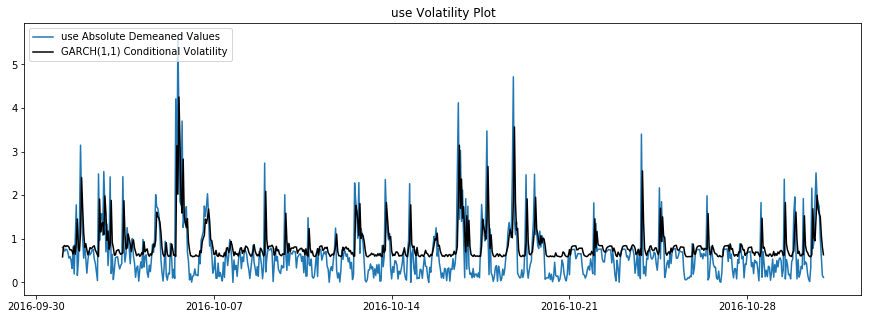

In [228]:
model.plot_fit(figsize=(15,5))

In [229]:
#prediction up to one week
garch_pred = model.predict_is(h=24*7)
garch_pred.rename(columns={'Series':'use'}, inplace=True)

#compute residuals from the predictions to plot out
residuals = garch_pred - df_4874.loc['2016-10-24 01:00:00':'2016-10-31 00:00:00',:]
residuals = residuals['use']

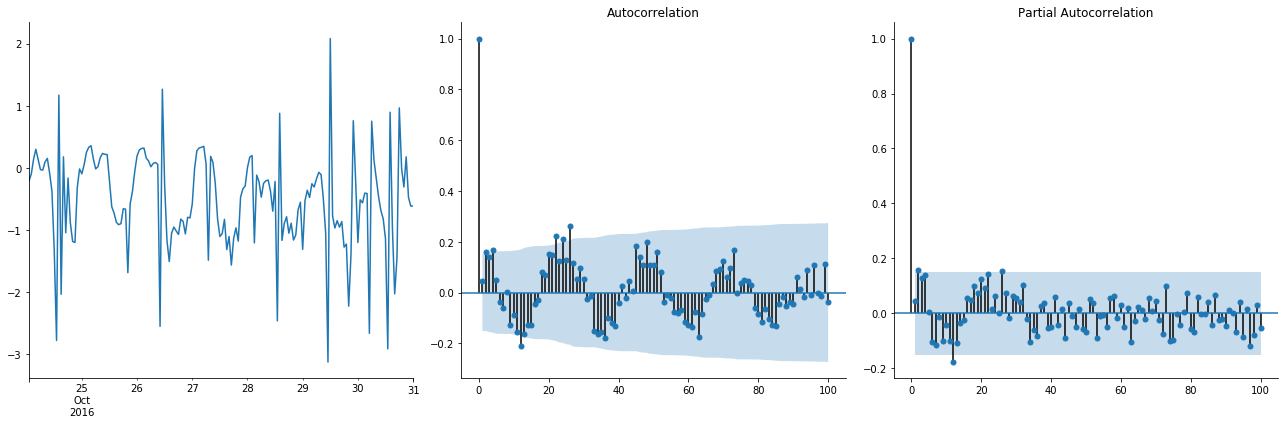

In [230]:
acf_pacf_plots(residuals, lags=100)

In [232]:
#prediction up to 1 day
garch_pred_2 = model.predict_is(h=24)
garch_pred_2.rename(columns={'Series':'use'}, inplace=True)

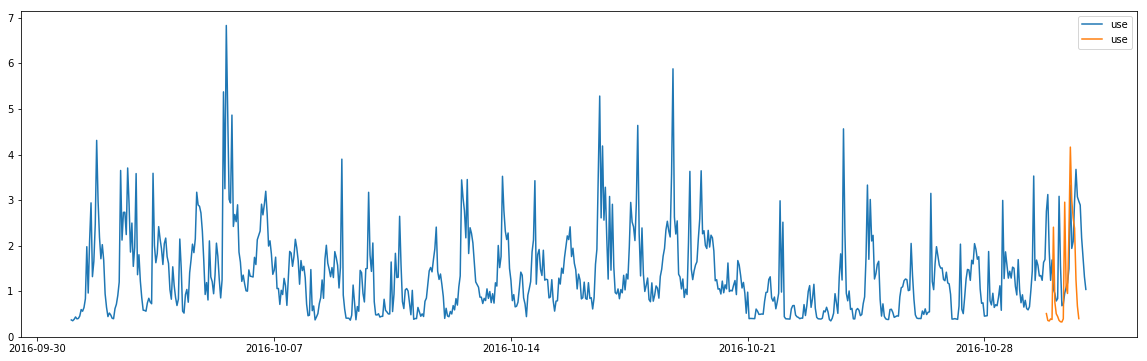

In [233]:
plt.subplots(1,1,figsize=(20,6))
plt.plot(df_4874.localhour, df_4874.use)
plt.plot(garch_pred_2.index,garch_pred_2.use)
plt.legend()

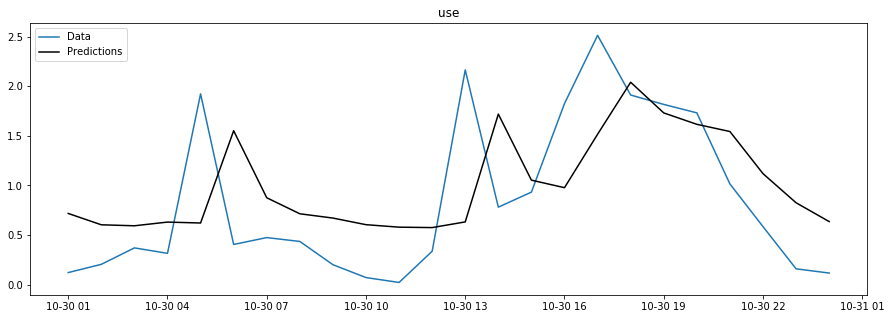

In [231]:
model.plot_predict_is(h=24,figsize=(15,5))

In [238]:
mean_squared_error(df_4874_test.use, garch_pred_2.use)

1.286224118817233

-----------------

## GARCH using `arch`

In [345]:
import arch

arch_model = arch.arch_model(df_4874.use, p=1, q=1)
results_3 = arch_model.fit(update_freq=5)
print(results_3.summary)

Iteration:      5,   Func. Count:     37,   Neg. LLF: 857.5600862542149
Iteration:     10,   Func. Count:     70,   Neg. LLF: 856.513665306034
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 856.5133810330773
            Iterations: 12
            Function evaluations: 82
            Gradient evaluations: 12
<bound method ARCHModelResult.summary of                      Constant Mean - GARCH Model Results                      
Dep. Variable:                    use   R-squared:                      -0.059
Mean Model:             Constant Mean   Adj. R-squared:                 -0.059
Vol Model:                      GARCH   Log-Likelihood:               -856.513
Distribution:                  Normal   AIC:                           1721.03
Method:            Maximum Likelihood   BIC:                           1739.35
                                        No. Observations:                  721
Date:                Tue, Sep 12 2017   Df Residuals:

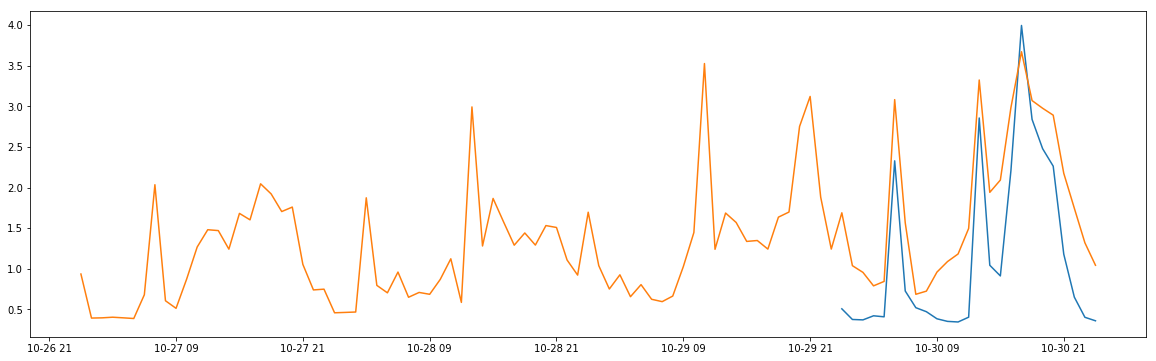

In [348]:
plt.subplots(1,1,figsize=(20,6))
arch_forecast = results_3.forecast(start='2016-10-30 00:00:00')
plt.plot(df_4874.localhour,arch_forecast.variance)
plt.plot(df_4874.loc['2016-10-27 00:00:00':, 'localhour'],df_4874.loc['2016-10-27 00:00:00':, 'use'])

In [347]:
mean_squared_error(df_4874.loc['2016-10-30 00:00:00':,'use'], arch_forecast.variance[-25:])

0.5585321707362042

### GARCH with exogenous variables

In [317]:
df_weather_austin = pickle.load(open('weather_austin.p', 'rb'))
df_weather_austin = df_weather_austin.sort_values('localhour', ascending=True)
df_weather_austin.index =pd.to_datetime(df_weather_austin.apply(strip_tz, axis=1))

In [327]:
df_4874_exog = add_exog(df_4874_train, '2016-10-01 00:00:00', '2016-10-31 00:00:00')

#fill missing temperature values
df_4874_exog['Temperature'] = df_4874_train.Temperature.fillna(np.mean(df_4874_train['Temperature']))

exogenous = df_4874_exog.loc['2016-10-01 00:00:00':,'Temperature'].astype(float)
endogenous = df_4874_exog.loc[:,'use'].astype(float)

In [333]:
arch_exog_model = arch.arch_model(df_4874.use, x=exogenous, p=1, q=1)
results_4 = arch_exog_model.fit(update_freq=5)
print(results_4.summary)

Iteration:      5,   Func. Count:     37,   Neg. LLF: 857.5600862542149
Iteration:     10,   Func. Count:     70,   Neg. LLF: 856.513665306034
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 856.5133810330773
            Iterations: 12
            Function evaluations: 82
            Gradient evaluations: 12
<bound method ARCHModelResult.summary of                      Constant Mean - GARCH Model Results                      
Dep. Variable:                    use   R-squared:                      -0.059
Mean Model:             Constant Mean   Adj. R-squared:                 -0.059
Vol Model:                      GARCH   Log-Likelihood:               -856.513
Distribution:                  Normal   AIC:                           1721.03
Method:            Maximum Likelihood   BIC:                           1739.35
                                        No. Observations:                  721
Date:                Tue, Sep 12 2017   Df Residuals:

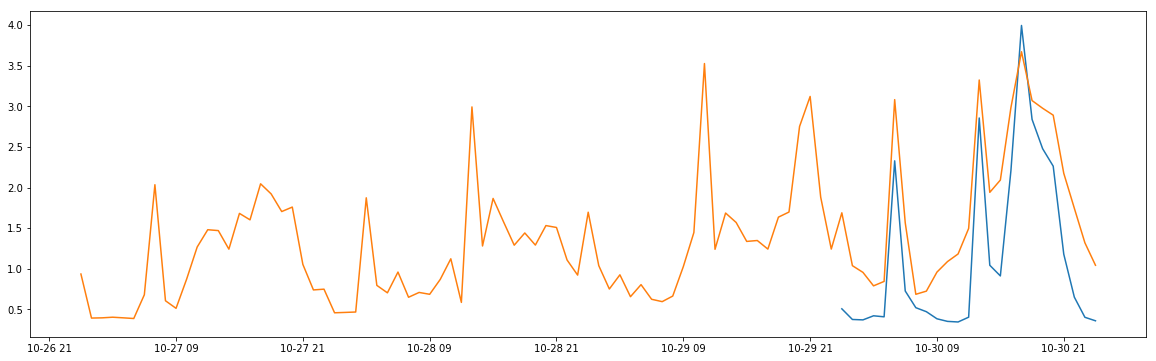

In [334]:
plt.subplots(1,1,figsize=(20,6))
arch_exog_forecast = results_4.forecast(start='2016-10-30 00:00:00')
plt.plot(df_4874.localhour,arch_exog_forecast.variance)
plt.plot(df_4874.loc['2016-10-27 00:00:00':, 'localhour'],df_4874.loc['2016-10-27 00:00:00':, 'use'])

In [332]:
mean_squared_error(df_4874.loc['2016-10-30 00:00:00':,'use'], arch_exog_forecast.variance[-25:])

0.5585321707362042